<img src="gwfish_priors_white.png" width="300" height="300"> 

# GWFish meets Priors
In Bayesian analysis, we start with prior beliefs about the parameters of the model, which represent our initial knowledge or assumptions. These priors can be informed by astrophysical models, previous observations, or theoretical predictions. As we observe a gravitational wave signal, we update these beliefs using the likelihood function, which quantifies the probability of observing the data given the parameters. The result is the posterior distribution, which represents our updated knowledge about the parameters after considering the data.

One of the advantages of the Bayesian approach is its ability to incorporate prior information and quantify uncertainties in a rigorous way. By combining prior knowledge with the observed data, we can make more informed inferences about the properties of the gravitational wave source.

$$p(\vec{\theta}|s) \propto \pi(\vec{\theta}){\mathcal{L}}(s|\vec{\theta})$$

The Fisher matrix analysis works in the assumption that when the signal to noise ratio (SNR) is sufficiently large, the likelihood is a highly peaked function and no priors are needed. However, this is rarely the case, as correlations may spread the likelihood and sampling from the multivariate Gaussian may leak outside the physical range of parameters. 

> **In this tutorial, we show how to integrate prior information, $\pi(\vec{\theta})$, into the Fisher likelihood while maintaining computational efficiency in the sampling process. Additionally, we offer insights into the comparative behavior of different prior choices.**

The procedure is addressed in a second `GWFish` paper available on [arXiv](https://arxiv.org/abs/2404.16103). The usage of the code as for the paper's purposes can be found in this [repo](https://github.com/u-dupletsa/GWFish-meets-Priors).

### Introducing the new modules
This part is based on the new module `priors.py` and the sampling procedure relies on the `minimax_tilting_sampler.py` module (see below). It consists in building on top of the standard `GWFish`output and incorporate prior information in post-processing.

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import GWFish.modules as gw
from GWFish.modules.priors import *

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import astropy

In [3]:
astropy.__version__

'5.3.4'

In [4]:
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = True

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

### Produce standard `GWfish` output
For a throughout guide refer to the main [`gwfish_tutorial.ipynb`](https://github.com/janosch314/GWFish/blob/main/gwfish_tutorial.ipynb)

In [5]:
# Event's parameters should be passed as Pandas dataframe
parameters = {
    'chirp_mass': np.array([20]), 
    'mass_ratio': np.array([0.75]), 
    'luminosity_distance': np.array([1000.]),
    'theta_jn': np.array([np.pi/4]),
    'ra': np.array([np.pi/4]),
    'dec': np.array([np.pi/4]),
    'psi': np.array([np.pi/4]),
    'phase': np.array([np.pi/4]),
    'geocent_time': np.array([1187008882]),
    'a_1':np.array([0.2]), 
    'a_2':np.array([0.2]),
    'tilt_1':np.array([np.pi/4]),
    'tilt_2':np.array([np.pi/4]),
    'phi_12':np.array([np.pi/4]),
    'phi_jl':np.array([np.pi/4])}
parameters = pd.DataFrame(parameters)
parameters

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl
0,20,0.75,1000.0,0.785398,0.785398,0.785398,0.785398,0.785398,1187008882,0.2,0.2,0.785398,0.785398,0.785398,0.785398


In [6]:
# The fisher parameters are the parameters that will be used to calculate the Fisher matrix
# and on which we will calculate the errors
fisher_parameters = list(parameters.keys())

In [7]:
detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = gw.detection.Network(detector_ids = ['LLO'], detection_SNR = (0., 8.)),
        parameter_values = parameters,
        fisher_parameters=fisher_parameters, 
        waveform_model = 'IMRPhenomXPHM',
        save_matrices = True # you need to save the covariance matrix for the next steps
        )

100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


## Post-processing with priors

In [8]:
np.random.seed(42) # fix for reproducibility
rng = np.random.default_rng()
# Decide the number of samples to draw
num_samples = int(1e6)

### Sampling from the multivariate-Gaussian 
We sample directly using the covariance matrix from `GWFish` without any prior on parameters

In [9]:
param_lbs = {'chirp_mass': r'$\mathcal{M}_c$ $[M_{\odot}]$', 'mass_ratio': r'$q$', 'luminosity_distance': r'$d_L$ [Mpc]',
                'dec': r'$\texttt{DEC}$ [rad]', 'ra': r'$\texttt{RA}$ [rad]', 'theta_jn': r'$\theta_{JN}$ [rad]', 'psi': r'$\Psi$ [rad]',
                'phase': r'$\phi$ [rad]', 'geocent_time': r'$t_c$ [rad][s]', 'a_1': r'$a_1$', 'a_2': r'$a_2$',
                'tilt_1': r'$\theta_1$ [rad]', 'tilt_2': r'$\theta_2$ [rad]', 'phi_12': r'$\phi_{12}$ [rad]',
                'phi_jl': r'$\phi_{JL}$ [rad]'}
 
mean_values = np.array(parameters[fisher_parameters ].iloc[0]) # mean values of the parameters
cov_matrix = np.load('inv_fisher_matrices.npy')[0, :, :]
fisher_samples = pd.DataFrame(rng.multivariate_normal(mean_values, cov_matrix, int(1e6)), columns = fisher_parameters)

## Minimax tilting sampling from truncated Gaussian
Some parameters (especially angles and spins), even with high SNR, may still be poorly measured and show a largely-spread likelihood. Consequently, when drawing likelihood samples, most samples lie outside the physical range of parameters. Therefore, we sample directly from the truncated form of the Gaussian likelihood to prevent drawing a large number of samples with null prior, which would have to be discarded. In particular, we rely on the algorithm developed in [Botev 2016](https://arxiv.org/abs/1603.04166) (we slighlty modified the code - publicly available on [GitHub](https://github.com/brunzema/truncated-mvn-sampler?tab=readme-ov-file)- based on this paper). This effectively accounts for the parameters' boundaries, ensuring the samples are in their physical range. 

The `minmax_tilting` algorithm explained in [Botev 2016](https://arxiv.org/abs/1603.04166) is roughly based on the following steps:
1. Identify target distribution for which direct sampling might be problematic (multi-dimensional truncated Gaussian)
2. Choose a family of tilting distributions that are easier to samples from (Gaussians in our case with adjustable parameters)
3. Choose best tilting parameters so that the maximum distance (the Kullback-Leibler (KL) divergence) between the auxiliar and the target distribution is minimized (hence *minimax*)
4. Sample from tilted distribution
5. Re-weight samples to match the target distribution

In [10]:
get_truncated_likelihood_samples?

Signature:
get_truncated_likelihood_samples(
    params,
    mean_values,
    cov_matrix,
    num_samples,
    min_array=None,
    max_array=None,
)
Docstring:
Generate truncated likelihood samples for the given parameters.

Parameters:
params (list): The list of parameters.
mean_values (array-like): The mean values for the parameters.
cov_matrix (array-like): The covariance matrix for the parameters.
num_samples (int): The number of samples to generate.
min_array (array-like): The lower bounds for the parameters.
mx_array (array-like): The upper bounds for the parameters.

! The default prior ranges are used if the min_array and max_array are not provided.

Returns:
array-like: Dataframe of truncated likelihood samples for the params.
File:      ~/Documents/GWFish-1/GWFish/modules/priors.py
Type:      function

In [11]:
# In priors.py the function get_truncated_likelihood_samples takes the following arguments:
# - fisher_parameters: list of parameters
# - mean_values: mean values of the parameters
# - cov_matrix: covariance matrix
# - num_samples: number of samples to draw
# - min_array: minimum values of the parameters
# - max_array: maximum values of the parameters
# The function returns the samples from the truncated likelihood
# You can get this information using the command shown in the cell above

# If min_array and max_array are not provided, the function will use the default range for each parameter
# specified in the default prior dictionary (these ranges are used to truncate the likelihood)

samples_from_truncated_lkh = get_truncated_likelihood_samples(fisher_parameters, mean_values, cov_matrix, num_samples)#, min_array, max_array)

In [12]:
# To avoid having a large number of samples outside the physical range, we apply the prior to the samples from
# the truncated likelihood. The function get_posteriors_samples takes the following arguments:
# - fisher_parameters: list of parameters
# - samples_from_truncated_lkh: samples from the truncated likelihood
# - num_samples: number of samples to draw
# - priors_dict: dictionary with the prior ranges for each parameter (if not provided, the default prior dictionary is used)

samples_from_posterior = get_posteriors_samples(fisher_parameters, samples_from_truncated_lkh, num_samples)#, priors_dict)

In [13]:
print_default_priors_dict(fisher_parameters)

chirp_mass: uniform_in_component_masses_chirp_mass in the interval [5, 100]
mass_ratio: uniform_in_component_masses_mass_ratio in the interval [0.0, 0.99]
luminosity_distance: uniform_in_comoving_volume_and_source_frame in the interval [10, 10000]
theta_jn: uniform_in_sine in the interval [0, 3.141592653589793]
ra: uniform in the interval [0, 6.283185307179586]
dec: uniform_in_cosine in the interval [-1.5707963267948966, 1.5707963267948966]
psi: uniform in the interval [0, 3.141592653589793]
phase: uniform in the interval [0, 6.283185307179586]
geocent_time: uniform in the interval [0, 10000000000.0]
a_1: uniform in the interval [0, 0.99]
a_2: uniform in the interval [0, 0.99]
tilt_1: uniform_in_sine in the interval [0, 3.141592653589793]
tilt_2: uniform_in_sine in the interval [0, 3.141592653589793]
phi_12: uniform in the interval [0, 6.283185307179586]
phi_jl: uniform in the interval [0, 6.283185307179586]


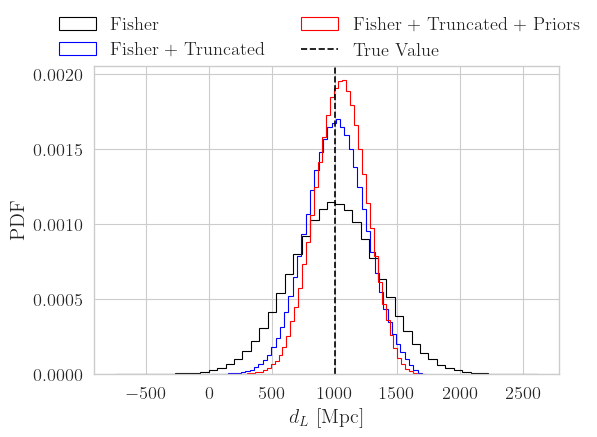

In [14]:
# Plot the posterior distribution of the parameter of choice
sel_param = 'luminosity_distance'

injections = np.array(mean_values)
fig = plt.figure(figsize=(6, 4))
plt.hist(fisher_samples[sel_param], bins=50, histtype='step', density=True,
            label='Fisher', alpha = 1., color = 'black')
plt.hist(samples_from_truncated_lkh[sel_param], bins=50, histtype='step', density=True,
            label='Fisher + Truncated', alpha = 1., color = 'blue')
plt.hist(samples_from_posterior[sel_param], bins=50, histtype='step', density=True,
            label='Fisher + Truncated + Priors', alpha = 1., color = 'red')
plt.axvline(injections[fisher_parameters.index(sel_param)], color='black', linestyle='--', label='True Value')
plt.xlabel(param_lbs[sel_param])
plt.ylabel('PDF')
fig.legend(loc='center', bbox_to_anchor=(0.5, 0.95), ncol=2, frameon=False)
plt.show()

### Priors dictionary example

In [15]:
priors_dict = {}
priors_dict['chirp_mass'] = {
    'prior_type': 'uniform_in_component_masses_chirp_mass',
    'lower_prior_bound': parameters['chirp_mass'].iloc[0] - 5.,
    'upper_prior_bound': parameters['chirp_mass'].iloc[0] + 5.
}
priors_dict['mass_ratio'] = {
    'prior_type': 'uniform_in_component_masses_mass_ratio',
    'lower_prior_bound': 0.05,
    'upper_prior_bound': 0.99
}
priors_dict['luminosity_distance'] = {
    'prior_type': 'uniform_in_distance_squared',
    'lower_prior_bound': 10,
    'upper_prior_bound': 10000
}
priors_dict['theta_jn'] = {
    'prior_type': 'uniform_in_sine',
    'lower_prior_bound': 0,
    'upper_prior_bound': np.pi
}
priors_dict['ra'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}
priors_dict['dec'] = {
    'prior_type': 'uniform_in_cosine',
    'lower_prior_bound': -np.pi/2,
    'upper_prior_bound': np.pi/2
}
priors_dict['psi'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': np.pi
}
priors_dict['phase'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}
priors_dict['geocent_time'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': parameters['geocent_time'].iloc[0] - 3,
    'upper_prior_bound': parameters['geocent_time'].iloc[0] + 3
}
priors_dict['a_1'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 1.
}
priors_dict['a_2'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 1.
}
priors_dict['tilt_1'] = {
    'prior_type': 'uniform_in_sine',
    'lower_prior_bound': 0.,
    'upper_prior_bound': np.pi
}
priors_dict['tilt_2'] = {
    'prior_type': 'uniform_in_sine',
    'lower_prior_bound': 0.,
    'upper_prior_bound': np.pi
}
priors_dict['phi_12'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}
priors_dict['phi_jl'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}

# How to choose priors?

For a broader discussion we invite to have a look at the appendix in [Dupletsa et al. 2024](https://arxiv.org/pdf/2404.16103). Here, we will focus on the masses as a pedagogical example.

## An in-depth look at priors: the case of masses
Choosing `chirp_mass` and `mass_ratio` parametrization offers a better outcome when doing the Fisher analysis, as they exhibit a more Gaussian behavior with respect to the `mass_1` and `mass_2` parametrization choice. It is customary, though, when it comes to the prior choice for the masses, to use a uniform in the component masses one (see the Bayesian analysis in the LIGO-Virgo-KAGRA Collaboration). In what follows, it is briefly shown how to sample in `chirp_mass` and `mass_ratio` with a uniform in component masses prior.

### Reweighting priors
We want to reweight our likelihood samples on $\mathcal{M}_{\rm chirp}$ and $q$, which are uniform in the $\mathcal{M}_{\rm chirp}$-$q$ plane, to a distribution of $\mathcal{M}_{\rm chirp}$ and $q$, that is uniform in the $m_1$-$m_2$ plane. This means that the uniform prior on $\mathcal{M}_{\rm chirp}$ and $q$ needs to be reweighted by the determinant of the Jacobian of the transformation:
$$
|J| = \bigg| \frac{\partial(m1, m2)}{\partial(\mathcal{M}_{\rm chirp},q)} \bigg| = \mathcal{M}_{\rm chirp}q^{-6/5}(1+q)^{2/5}
$$,
since the prior probability needs to be uniform in $m_1$-$m_2$:
$$
\pi(\mathcal{M}_{\rm chirp},q) = \pi   \big[ m_1(\mathcal{M}_{\rm chirp},q), m_2(\mathcal{M}_{\rm chirp},q) \big] \bigg| \frac{\partial(m1, m2)}{\partial(\mathcal{M}_{\rm chirp},q)} \bigg|
$$

#### Step-by-step derivation of the Jacobian
We need to express $m_1$ and $m_2$ as functions of $\mathcal{M}_{\rm chirp}$ and $q$:
$$
\begin{cases}
m_1 &= \mathcal{M}_{\rm chirp}q^{-3/5}(1+q)^{1/5}\\
m_2 &= \mathcal{M}_{\rm chirp}q^{2/5}(1+q)^{1/5}
\end{cases}
$$
Therefore, the Jacobian matrix is:
$$
J =
\begin{pmatrix}
\frac{\partial m_1}{\partial \mathcal{M}_{\rm chirp}} &\frac{\partial m_1}{\partial q}\\
\frac{\partial m_2}{\partial \mathcal{M}_{\rm chirp}} &\frac{\partial m_2}{\partial q}
\end{pmatrix} = 
\begin{pmatrix}
\frac{(1+q)^{1/5}}{q^{3/5}} &\frac{\mathcal{M}_{\rm chirp}}{5}(1+q)^{-4/5}q^{-8/5}(-3-2q)\\
q^{2/5}(1+q)^{1/5} &\frac{\mathcal{M}_{\rm chirp}}{5}(1+q)^{-4/5}q^{-3/5}(2+3q)
\end{pmatrix}
$$
The determinant of the Jacobian is then:
$$
|J| = \mathcal{M}_{\rm chirp}q^{-6/5}(1+q)^{2/5}
$$

In [16]:
def from_mChirp_q_to_m1_m2(mChirp, q):
    """
    Compute the transformation from mChirp, q to m1, m2
    """
    m1 = mChirp * (1 + q)**(1/5) * q**(-3/5)
    m2 = mChirp * (1 + q)**(1/5) * q**(2/5)
    return m1, m2

In [17]:
N = 100000 # number of samples
# start with a uniform distribution in mChirp and q
mChirp = np.random.uniform(20, 30, N)
q = np.random.uniform(0.05, 0.99, N)

In [18]:
# distribution in the m1-m2 plane with a uniform distribution in mChirp and q
m1_uniform_in_Mc_q, m2_uniform_in_Mc_q = from_mChirp_q_to_m1_m2(mChirp, q)

In [19]:
mass_prior = (q**(-6/5)*mChirp*(1+q)**(2/5)) # jacobian from m1, m2 to mChirp, q
weights = mass_prior/mass_prior.sum()
index = np.random.choice(np.arange(N), size = N, replace = True, p = weights)
posteriors_mChirp = mChirp[index]
posteriors_q = q[index]

# distribution in the m1-m2 plane after the reweighting
# with a uniform in component masses prior
m1_uniform_in_m1m2, m2_uniform_in_m1m2 = from_mChirp_q_to_m1_m2(posteriors_mChirp, posteriors_q)

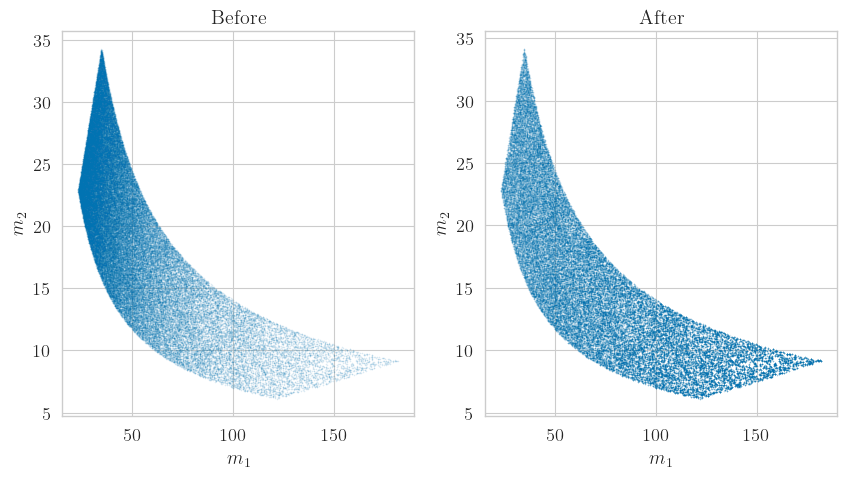

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(m1_uniform_in_Mc_q, m2_uniform_in_Mc_q, alpha=0.5, s=0.01, label='before')
ax[0].set_xlabel(r'$m_1$', fontsize=14)
ax[0].set_ylabel(r'$m_2$', fontsize=14)
ax[0].set_title('Before')

ax[1].scatter(m1_uniform_in_m1m2, m2_uniform_in_m1m2, alpha=0.5, s=0.01, label='after')
ax[1].set_xlabel(r'$m_1$', fontsize=14)
ax[1].set_ylabel(r'$m_2$', fontsize=14)
ax[1].set_title('After')

plt.show()

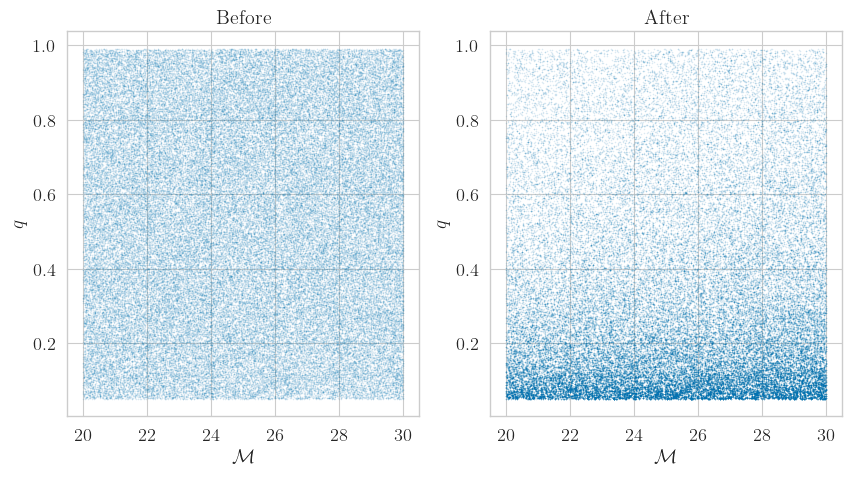

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(mChirp, q, alpha=0.5, s=0.01, label='before')
ax[0].set_xlabel(r'$\mathcal{M}$', fontsize=14)
ax[0].set_ylabel(r'$q$', fontsize=14)
ax[0].set_title(r'Before')

ax[1].scatter(posteriors_mChirp, posteriors_q, alpha=0.5, s=0.01, label='after')
ax[1].set_xlabel(r'$\mathcal{M}$', fontsize=14)
ax[1].set_ylabel(r'$q$', fontsize=14)
ax[1].set_title(r'After')

plt.show()

From the plots, one can notice how we pass from a distribution that starts uniform in the `chirp_mass` and `mass_ratio` plane, and ends up with one uniform in the `mass_1` and `mass_2` plane, while keeping the sampling in `chirp_mass` and `mass_ratio`.

## Comparing priors on luminosity distance

In [22]:
# Start with a uniform distribution in luminosity distance
N = 100000
luminosity_distance = np.random.uniform(10, 10000, N)

In [23]:
# Uniform in distance squared prior
dL2_prior = uniform_in_distance_squared(luminosity_distance) # using the function from prior.py with custom range
weights = dL2_prior/dL2_prior.sum()
index = np.random.choice(np.arange(N), size = N, replace = True, p = weights)
posteriors_dL2prior = luminosity_distance[index]

In [24]:
# Uniform in comoving volume prior
com_prior = uniform_in_comoving_volume(luminosity_distance) # using the function from prior.py with custom range
weights = com_prior/com_prior.sum()
index = np.random.choice(np.arange(N), size = N, replace = True, p = weights)
posteriors_dL2comoving = luminosity_distance[index]

In [25]:
# Uniform in comoving volume and source time prior
com_time_prior = uniform_in_comoving_volume_and_source_frame(luminosity_distance) # using the function from prior.py with custom range
weights = com_time_prior/com_time_prior.sum()
index = np.random.choice(np.arange(N), size = N, replace = True, p = weights)
posteriors_dL2comovingtime = luminosity_distance[index]

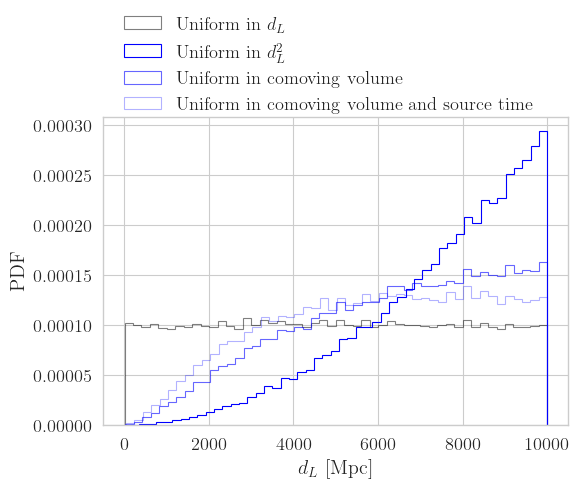

In [26]:
# Compare the histograms of the different priors on one plot
fig = plt.figure(figsize=(6, 4))
plt.hist(luminosity_distance, bins=50, histtype='step', density=True,
            label='Uniform in $d_L$', alpha = 0.5, color = 'black')
plt.hist(posteriors_dL2prior, bins=50, histtype='step', density=True,
            label='Uniform in $d_L^2$', alpha = 1., color = 'blue')
plt.hist(posteriors_dL2comoving, bins=50, histtype='step', density=True,
            label='Uniform in comoving volume', alpha = 0.6, color = 'blue')
plt.hist(posteriors_dL2comovingtime, bins=50, histtype='step', density=True,
            label='Uniform in comoving volume and source time', alpha = 0.3, color = 'blue')
plt.xlabel(r'$d_L$ [Mpc]')
plt.ylabel('PDF')
fig.legend(loc='center', bbox_to_anchor=(0.5, 1.01), ncol=1, frameon=False)
plt.show()
